<a href="https://colab.research.google.com/github/wumingxiaozu103/baseline/blob/main/ADDR_ELEMENT_wwm_base_mlm_rdrop_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers sentencepiece pytorch-crf

     |████████████████████████████████| 2.5 MB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 23.5 MB/s 
     |████████████████████████████████| 895 kB 37.4 MB/s 
     |████████████████████████████████| 3.3 MB 44.0 MB/s 


In [ ]:
import matplotlib

import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm.auto import tqdm
import json
import random
import os

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertForTokenClassification, BertTokenizerFast, AdamW
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
from torchcrf import CRF

from matplotlib import pyplot as plt
import joblib
import re
import gc
from torch.optim.lr_scheduler import LambdaLR

from collections import defaultdict, Counter

from  torch.cuda.amp import GradScaler, autocast
import shutil
from sklearn.metrics import f1_score

print(f'using {torch.cuda.get_device_name(device=None)}')

2021-07-22 08:54:21,960 wwm_base_mlm_rdrop_cnn Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2021-07-22 08:54:22,254 wwm_base_mlm_rdrop_cnn Creating converter from 7 to 5
2021-07-22 08:54:22,255 wwm_base_mlm_rdrop_cnn Creating converter from 5 to 7
2021-07-22 08:54:22,257 wwm_base_mlm_rdrop_cnn Creating converter from 7 to 5
2021-07-22 08:54:22,258 wwm_base_mlm_rdrop_cnn Creating converter from 5 to 7


using Tesla P100-PCIE-16GB


In [ ]:
CFG = {
    'name': 'wwm_base_mlm_rdrop_cnn',
    'model': 'hfl/chinese-roberta-wwm-ext',
    'seed': 22,
    'batch_size': 64,
    'max_patient': 99,
    'total_step': 4000,
    'eval_very': 100,
}

In [ ]:
work_dir = os.path.join('/content/drive/Shareddrives/wzlnot/addr_element/', CFG['name'])
if os.path.exists(work_dir):
  shutil.rmtree(work_dir, ignore_errors=True)
  os.mkdir(work_dir)
else:
  os.mkdir(work_dir)

In [ ]:
train_file = '/content/drive/Shareddrives/wzlnot/addr_element/train.conll'
dev_file = '/content/drive/Shareddrives/wzlnot/addr_element/dev.conll'
test_file = '/content/drive/Shareddrives/wzlnot/addr_element/final_test.txt'
pesudo_test_file = '/content/drive/Shareddrives/wzlnot/addr_element/unkown_addr_parsing_runid.txt'

In [ ]:
def parse_data(file):
  with open(file) as f:
    raw = f.read()
  if raw.endswith('\n'): raw = raw[:-1]
  data = []
  for r in raw.split('\n\n'):
    if r.endswith('\n'): r = r[:-1]
    split_text = []
    label = []
    for e in r.split('\n'):
      assert len(e.split(' ')) == 2, (e,r)
      t, lab = e.split(' ')
      split_text.append(t)
      label.append(lab)
    data.append({'split_text': split_text, 'label': label})
  return data

In [ ]:
def parse_pesudo(file):
  with open(file) as f:
    raw = f.read()
  raw = re.sub(r'[\u200e\u200b\u200d]', '\u201d', raw) # \u200e \u200b \u200d can not encode, but \u201d can be encode to [UNK]
  if raw.endswith('\n'): raw = raw[:-1]
  data = []
  for r in raw.split('\n'):
    _, text, labels = r.split('\u0001')
    split_text = list(text)
    label = labels.split(' ')
    data.append({'split_text': split_text, 'label': label})
  return data

In [ ]:
def tokenize_and_align_labels(tokenizer, texts, label_ids, label_all_tokens=True):
    """
    texts: list of reocrds which is a list of word.
    label_ids: as text, list of reocrds which is a list of label of word.
    label_all_tokens: set the label to either the current label or -100.
    """
    outputs = []
    for i, label_id in enumerate(label_ids):
        tokenized_inputs = tokenizer.encode_plus(texts[i], is_split_into_words=True, return_tensors='pt')
        word_ids = tokenized_inputs.word_ids(batch_index=0)
        previous_word_idx = None
        align_label_id = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                align_label_id.append(0)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                align_label_id.append(label_id[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                align_label_id.append(label_id[word_idx] if label_all_tokens else 0)
            previous_word_idx = word_idx

        tokenized_inputs.update({"labels": torch.LongTensor(align_label_id)})
        tokenized_inputs.update({"text": texts[i]})
        outputs.append(tokenized_inputs)
    return outputs

In [ ]:
def collect_func(x):
  output = {}
  for k in x[0]:
    if k != 'text':
      # output[k] = pad_sequence([i[k].squeeze(0) for i in x], batch_first=True, padding_value= -100 if k=='labels' else 0)
      output[k] = pad_sequence([i[k].squeeze(0) for i in x], batch_first=True)
    else:
      output[k] = [i[k] for i in x]
  return output

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def deepcopy_state_dict_to_cpu(model):
    output = {}
    for k, v in model.state_dict().items():
        output[k] = deepcopy(v.cpu())
    return output

In [ ]:
def inference_entity(text, label):
  output = []
  curr_type = None
  curr_entity = []
  for t, l in zip(text, label):
    if l.startswith("S"):
      curr_type = None
      curr_entity = []
      output.append(t)
    elif l.startswith("B"):
      curr_entity = [t]
      curr_type = l.split('-')[1]
    elif l.startswith("E"):
      _curr_type = l.split('-')[1]
      if _curr_type == curr_type and len(curr_entity) > 0:
        curr_entity.append(t)
        output.append(''.join(curr_entity))
        curr_entity =[]
        curr_type = None
      else:
        curr_entity =[]
        curr_type = None
    elif l.startswith("I"):
      _curr_type = l.split('-')[1]
      if _curr_type == curr_type and len(curr_entity) > 0:
        curr_entity.append(t)
      else:
        curr_entity =[]
        curr_type = None
    else:
      curr_entity =[]
      curr_type = None
  return set(output)

def post_process(labels):
  if labels[-1].startswith('I'):
    labels[-1] = 'E' + labels[-1][1:]
  labels = [l if l != 'AAA' else 'O' for l in labels]
  return labels


def test_step_score(model, dl, device):
    model.eval()
    P = 0
    G = 0
    PG = 0
    with torch.no_grad():
        for data in dl:
            texts = deepcopy(data['text'])
            del(data['text'])
            for k in data: data[k] = data[k].to(device)
            _, pred = model(**data)
            gt_ = data['labels'].cpu().numpy()
            for bi in range(len(pred)):
              _text = texts[bi]
              pred_label = []
              gt_label = []
              for i, v in enumerate(pred[bi]):
                if gt_[bi][i+1] != 0:
                  gt_label.append(lbs.classes_[gt_[bi][i+1]])
                  pred_label.append(lbs.classes_[v])
              pred_label = post_process(pred_label)
            
              p = inference_entity(_text, pred_label)
              g = inference_entity(_text, gt_label)
              P += len(p)
              G += len(g)
              PG += len(p&g)

    return 2*PG/(G+P)

def test_step(model, dl, device):
    model.eval()
    gts = []
    predicts = []
    with torch.no_grad():
        for data in dl:
            del(data['text'])
            for k in data: data[k] = data[k].to(device)
            _, pred = model(**data)
            gt_ = data['labels'].cpu().numpy()
            for bi in range(len(pred)):
              for i, v in enumerate(pred[bi]):
                if gt_[bi][i+1] != 0:
                  gts.append(gt_[bi][i+1])
                  predicts.append(v)
    return f1_score(gts, predicts, average='micro')

def train_in_step(model, optimizer, lrs, train_dl, val_dl, device, total_steps, eval_every, max_patient):
    best_score = 0
    best_model = deepcopy_state_dict_to_cpu(model)
   
    hist = History(score_type='max')
    patient = 0
    
    pbar = tqdm(range(total_steps), desc = f"TRAIN")
    ds_iter = iter(train_dl)

    scaler = GradScaler()

    for curr_step in pbar:
        try:
            data = next(ds_iter)
        except StopIteration:
            ds_iter = iter(train_dl)
            data = next(ds_iter)
        model.train()
        optimizer.zero_grad()
        lrs.step()
        if 'text' in data: del(data['text'])
        for k in data: data[k] = data[k].to(device)

        with autocast():
            loss, _ = model.forward(**data)
        
        scaler.scale(loss).backward()
        # scaler.unscale_(optimizer)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        hist.step_update(loss.item(), optimizer.param_groups[0]['lr'])
        status = hist.get_status()
        status.update({'patient': patient})
        pbar.set_postfix(status)
        
        
        if curr_step % eval_every == eval_every-1:
            score = test_step_score(model, val_dl, device)
            hist.add_score(score, model)
            if score > best_score:
                best_score = score
                best_model = deepcopy_state_dict_to_cpu(model)
                patient = 0
            else:
                patient += 1
                if patient > max_patient:
                    print('reach max patient, break')
                    break
    return best_score, best_model, hist

def predict_step(model, dl, device):
    model.eval()
    predicts = []
    with torch.no_grad():
        for data in dl:
            del(data['text'])
            for k in data: data[k] = data[k].to(device)
            _, pred = model(**data)
            gt_ = data['labels'].cpu().numpy()
            for bi in range(len(pred)):
              predicts.append([v for i, v in enumerate(pred[bi]) if gt_[bi][i+1] != 0])
    return predicts

In [ ]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_rate, last_epoch=-1):

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps)) * (1 - min_rate) + min_rate
        return max(
            min_rate, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

class History():

    def __init__(self, score_type='min', binsize=50):
        self.loss = []
        self.score = []
        self.lr = []
        self.l2 = []
        self.step = 0
        self.eval_steps = []
        self.score_type = score_type
        self.binsize = binsize

    def step_update(self, loss, lr):
        self.step += 1
        self.loss.append(loss)
        self.lr.append(lr)

    def add_score(self, score, model):
        self.eval_steps.append(self.step)
        self.score.append(score)
        self.l2.append(self.cal_model_l2(model))

    def get_status(self):
        avg_loss = np.mean(self.loss[-self.binsize:]) if len(self.loss) > 0 else np.inf
        if self.score:
            last_score = self.score[-1]
            best_score = np.min(self.score) if self.score_type == 'min' else np.max(self.score)
        else:
            last_score = best_score = np.inf if self.score_type == 'min' else -np.inf
        lr = self.lr[-1] if self.lr else 0
        l2 = self.l2[-1] if self.l2 else np.inf
        return {"loss": avg_loss, 'last_score': last_score, 'best_score': best_score, 'lr': lr, 'l2': l2}
        
    def cal_model_l2(self, model):
        return torch.sqrt(sum([torch.pow(v, 2).sum() for k, v in model.state_dict().items() if 'position_ids' not in k])).item()

    def plot(self, max_rate):
        fig = plt.figure(figsize=(10,6))
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)

        x = np.arange(0, self.step, self.binsize)
        y_loss = [np.mean(self.loss[max(0, i-self.binsize):i+1]) for i in x]
        y_loss_min = np.min(y_loss)
        y_loss = np.clip(y_loss, a_min=y_loss_min, a_max=max_rate*y_loss_min)
        
        ax1.set_ylabel('loss')
        ax1.plot(x, y_loss, '-',label="loss")
        ax1s = ax1.twinx()
        ax1s.set_ylabel('score')
        score = -np.array(self.score) if self.score_type == 'min' else np.array(self.score)
        ax1s.plot(self.eval_steps, score, '-r', label="score")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1s.get_legend_handles_labels()
        ax1s.legend(lines1+lines2,labels1+labels2, loc=0)
        best_score_pos = (self.eval_steps[np.argmax(score)], max(score))
                        
        ax1s.annotate(f"best:{max(score):.4f}", xy=best_score_pos,
                    xytext=(best_score_pos[0]*0.9, (best_score_pos[1]+max(score))/2), fontsize=12, color='green',
                    arrowprops=dict(arrowstyle='<-', color='green', linewidth=1))
        ax2.set_ylabel('lr')
        
        ax2.plot(x, np.array(self.lr)[x], '-', label="lr")
        ax2s = ax2.twinx()
        ax2s.set_ylabel('l2')
        
        ax2s.plot(self.eval_steps, self.l2, '-r', label="l2")
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2s.get_legend_handles_labels()
        ax2s.legend(lines1+lines2,labels1+labels2, loc=1)
        return plt

In [ ]:
class BertCRT(nn.Module):

  def __init__(self, backbone, num_labels, windows_size=5, drop_rate=0.3, alpha=0.5):
    super().__init__()
    self.alpha=alpha
    self.num_labels = num_labels

    self.backbone = backbone
    self.pooling = nn.Sequential(
        nn.Linear(self.backbone.config.hidden_size, self.backbone.config.hidden_size),
        nn.Tanh())
    self.cnn = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(windows_size, 1), padding='same')
    self.rdropout =  nn.Sequential(nn.Dropout(0.3), nn.Dropout(0.3))
    self.classifier = nn.Linear(self.backbone.config.hidden_size,self.num_labels)
    self.crf = CRF(self.num_labels, batch_first=True)
  
  def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,):

    outputs = self.backbone(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )

    hidden = self.rdropout(self.cnn(self.pooling(outputs[0]).unsqueeze(1)).squeeze(1))

    logits = self.classifier(hidden)
    
    loss_mask = attention_mask.bool().bool()
    loss = None
    if labels is not None:
      outputs1 = self.backbone(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict)

      hidden1 = self.rdropout(self.cnn(self.pooling(outputs1[0]).unsqueeze(1)).squeeze(1))

      logits1 = self.classifier(hidden1)

      ce_loss = -self.crf(logits[:,1:], labels[:,1:], mask=loss_mask[:,1:], reduction='mean')
      ce_loss_1 = -self.crf(logits1[:,1:], labels[:,1:], mask=loss_mask[:,1:], reduction='mean')
      kl_loss = compute_kl_loss(logits[:,1:], logits1[:,1:], loss_mask[:,1:]!=1)
      loss = 0.5*ce_loss + 0.5*ce_loss_1 + self.alpha * kl_loss
    
    loss_mask = attention_mask.bool().bool()

    if labels is not None:
      loss = -self.crf(logits[:,1:], labels[:,1:], mask=loss_mask[:,1:], reduction='mean')
    prediction = self.crf.decode(logits[:,1:], mask=loss_mask[:,1:])
    return loss, prediction

def compute_kl_loss(p, q, pad_mask=None):    
    p_loss = F.kl_div(F.log_softmax(p, dim=-1), F.softmax(q, dim=-1), reduction='none').sum(-1)
    q_loss = F.kl_div(F.log_softmax(q, dim=-1), F.softmax(p, dim=-1), reduction='none').sum(-1)
  
    # pad_mask is for seq-level tasks
    if pad_mask is not None:
        p_loss.masked_fill_(pad_mask, 0.)
        q_loss.masked_fill_(pad_mask, 0.)

    # You can choose whether to use function "sum" and "mean" depending on your task
    p_loss = p_loss.sum(-1) / (pad_mask != 0).sum(-1)
    q_loss = q_loss.sum(-1) / (pad_mask !=0).sum(-1)

    p_loss = p_loss.sum()
    q_loss = q_loss.sum() 

    loss = (p_loss + q_loss) / 2
    return loss

In [ ]:
import logging

def set_logging(tag):
  logger = logging.getLogger() # no parameter means the root logger
  formatter = logging.Formatter(f"%(asctime)s {tag} %(message)s")
  handler2 = logging.StreamHandler()
  handler2.setFormatter(formatter)
  handler2.setLevel(logging.DEBUG)
  logger.addHandler(handler2)
  logger.setLevel(logging.DEBUG)

def info(s):
  logging.info(s)

set_logging(CFG['name'])

In [ ]:

def check(label_list, verbose=0):
  i = 0
  while i < len(label_list):
    if label_list[i].startswith('S') or label_list[i] == "O":
      i += 1
    elif label_list[i].startswith('B'):
      if i == len(label_list) -1:
        return False
      _, cls = label_list[i].split('-')
      find_end = False
      for j in range(i+1, len(label_list)):
        if find_end:
          i = j
          break
        else:
          if label_list[j].startswith('S') or label_list[j] == "O":
            return False
          try:
            curr_head, curr_cls = label_list[j].split('-')
          except ValueError:
            return False
            raise ValueError(label_list[j], label_list)
        
          if curr_head == "I":
            continue
          elif curr_head == "E":
            find_end=True
            continue
          else:
            if verbose: print(3)
            return False
      if j == len(label_list) -1:
        if find_end:
          return True
        else:
          if verbose: print(4)
          return False
    else:
      if verbose: print(5)
      return False
  return True

def post_process(labels):
  if labels[-1].startswith('I'):
    labels[-1] = 'E' + labels[-1][1:]
  for i in range(1, len(labels)):
    if labels[i].startswith('B') and labels[i-1].startswith('I'):
      labels[i-1] = 'E' + labels[i-1][1:]
  labels = [l if l != 'AAA' else 'O' for l in labels]
  return labels

2021-07-22 11:54:52,209 wwm_base_mlm_rdrop_cnn loading test
2021-07-22 11:55:01,649 wwm_base_mlm_rdrop_cnn Starting new HTTPS connection (1): huggingface.co:443
2021-07-22 11:55:02,367 wwm_base_mlm_rdrop_cnn https://huggingface.co:443 "HEAD /hfl/chinese-roberta-wwm-ext/resolve/main/vocab.txt HTTP/1.1" 200 0
2021-07-22 11:55:02,372 wwm_base_mlm_rdrop_cnn Starting new HTTPS connection (1): huggingface.co:443
2021-07-22 11:55:03,087 wwm_base_mlm_rdrop_cnn https://huggingface.co:443 "HEAD /hfl/chinese-roberta-wwm-ext/resolve/main/tokenizer.json HTTP/1.1" 200 0
2021-07-22 11:55:03,092 wwm_base_mlm_rdrop_cnn Starting new HTTPS connection (1): huggingface.co:443
2021-07-22 11:55:03,806 wwm_base_mlm_rdrop_cnn https://huggingface.co:443 "HEAD /hfl/chinese-roberta-wwm-ext/resolve/main/added_tokens.json HTTP/1.1" 200 0
2021-07-22 11:55:03,811 wwm_base_mlm_rdrop_cnn Starting new HTTPS connection (1): huggingface.co:443
2021-07-22 11:55:04,526 wwm_base_mlm_rdrop_cnn https://huggingface.co:443 "HEAD

fold: 0


Some weights of the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning and are

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


reach max patient, break


2021-07-22 12:15:49,192 wwm_base_mlm_rdrop_cnn fold-0 best is 0.9613085274283801


predict


2021-07-22 12:18:26,356 wwm_base_mlm_rdrop_cnn fold-0 bad case: 0
2021-07-22 12:18:27,153 wwm_base_mlm_rdrop_cnn fold-0 bad case after pp: 0


fold: 1


Some weights of the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning and are

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


reach max patient, break


2021-07-22 12:37:29,674 wwm_base_mlm_rdrop_cnn fold-1 best is 0.9589410348977137


predict


2021-07-22 12:40:07,055 wwm_base_mlm_rdrop_cnn fold-1 bad case: 0
2021-07-22 12:40:07,807 wwm_base_mlm_rdrop_cnn fold-1 bad case after pp: 0


fold: 2


Some weights of the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning and are

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


reach max patient, break


2021-07-22 12:56:43,387 wwm_base_mlm_rdrop_cnn fold-2 best is 0.9592326139088729


predict


2021-07-22 12:59:19,909 wwm_base_mlm_rdrop_cnn fold-2 bad case: 0
2021-07-22 12:59:20,658 wwm_base_mlm_rdrop_cnn fold-2 bad case after pp: 0


fold: 3


Some weights of the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning and are

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


reach max patient, break


2021-07-22 13:20:56,278 wwm_base_mlm_rdrop_cnn fold-3 best is 0.961657833166213


predict


2021-07-22 13:23:33,189 wwm_base_mlm_rdrop_cnn fold-3 bad case: 0
2021-07-22 13:23:33,944 wwm_base_mlm_rdrop_cnn fold-3 bad case after pp: 0


fold: 4


Some weights of the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning and are

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


reach max patient, break


2021-07-22 13:41:00,269 wwm_base_mlm_rdrop_cnn fold-4 best is 0.9621960486322189


predict


2021-07-22 13:43:36,716 wwm_base_mlm_rdrop_cnn fold-4 bad case: 0
2021-07-22 13:43:37,411 wwm_base_mlm_rdrop_cnn fold-4 bad case after pp: 0
2021-07-22 13:43:37,413 wwm_base_mlm_rdrop_cnn oof score: 0.9606672116066797


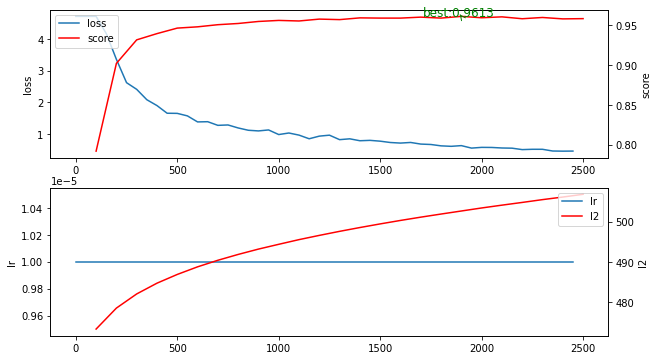

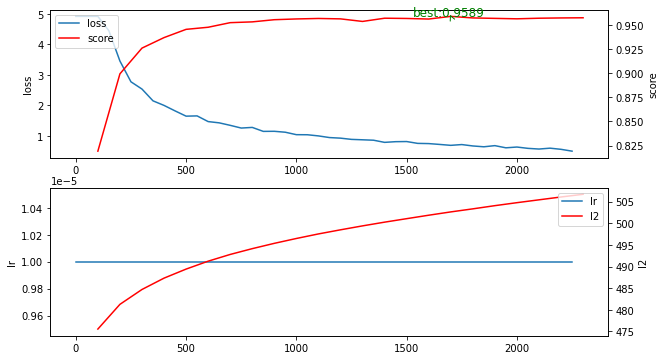

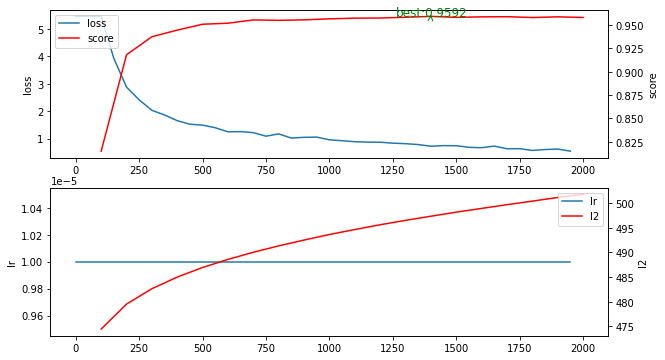

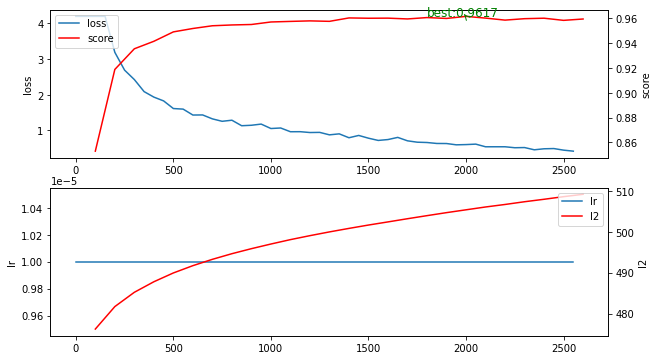

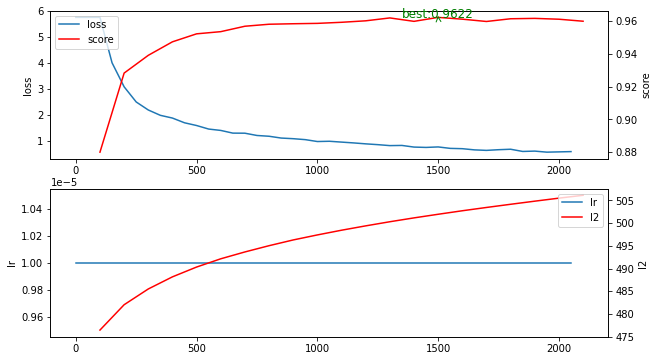

In [ ]:
scores = []
CFG['max_patient'] = 5

gc.collect()
torch.cuda.empty_cache()

info('loading test')
with open(test_file) as f:
  raw =f.read().strip()
raw = re.sub(r'[\u200e\u200b\u200d]', '\u201d', raw) # \u200e \u200b \u200d can not encode, but \u201d can be encode to [UNK]
test = []
for r in raw.split('\n'):
  assert len(r.split('\u0001')) == 2, r
  no,text = r.split('\u0001')
  test.append({'text': text, 'no': no})

test_ds = tokenize_and_align_labels(tokenizer, [list(i['text']) for i in test], [np.ones(len(i['text'])) for i in test])
test_dataloader = DataLoader(test_ds, shuffle=False, batch_size=CFG['batch_size'], collate_fn=collect_func, num_workers=2)

tokenizer = BertTokenizerFast.from_pretrained(CFG['model'])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# no_decay = ['.bias', 'LayerNorm.bias', 'LayerNorm.weight', 'pooler', 'task']
no_decay = ['.bias', 'LayerNorm.bias', 'LayerNorm.weight']

seed_everything(CFG['seed'])
train = parse_data(train_file)
val = parse_data(dev_file)
data = train+val
lbs = LabelEncoder()
lbs.fit(['AAA'] + [l for i in data for l in i['label']])
k_fold = KFold(5, shuffle=True, random_state=CFG['seed'])

oof_predicts = []

for fold_i, (train_idx, val_idx) in enumerate(k_fold.split(data)):
  print(f"fold: {fold_i}")
  train =[data[i] for i in train_idx]
  val = [data[i] for i in val_idx]  
  train_ds = tokenize_and_align_labels(tokenizer, [i['split_text'] for i in train], [lbs.transform(i['label']) for i in train])
  val_ds = tokenize_and_align_labels(tokenizer, [i['split_text'] for i in val], [lbs.transform(i['label']) for i in val])
  train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=CFG['batch_size'], collate_fn=collect_func, num_workers=4)
  val_dataloader = DataLoader(val_ds, shuffle=False, batch_size=CFG['batch_size'], collate_fn=collect_func, num_workers=4)
    
  model = BertCRT(BertModel.from_pretrained('/content/drive/Shareddrives/wzlnot/addr_element/mlm_tuning'), num_labels=len(lbs.classes_))

  model.to(device)
      
  optimizer = AdamW([
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and 'crf' not in n],
      'lr': 1e-5, 'weight_decay': 1e-3},
      {'params': [p for n, p in model.named_parameters() if 'crf' in n],
      'lr': 5e-2, 'weight_decay': 1e-3},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and 'crf' not in n],
      'lr': 1e-5, 'weight_decay': 0}])

  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=200, num_training_steps=1000, min_rate=1)
  best_score, best_model, hist = train_in_step(model, optimizer, lr_scheduler, train_dataloader, val_dataloader, device, CFG['total_step'], CFG['eval_very'], CFG['max_patient'])
  scores.append(best_score)
  torch.save(best_model, os.path.join(work_dir, f'model_{fold_i}.pth'))
  hist.plot(10).savefig(os.path.join(work_dir, f'history_{fold_i}.png'))
  info(f'fold-{fold_i} best is {best_score}')
  
  print('predict')
  model.load_state_dict(best_model)
  # model.to(device)
  preds = predict_step(model, test_dataloader, device)
  pred_labels = [[lbs.classes_[j] for j in i] for i in preds]
  info(f'fold-{fold_i} bad case: {len([i for i in pred_labels if not check(i)])}')

  pp_pred_labels = [post_process(i) for i in pred_labels]
  info(f'fold-{fold_i} bad case after pp: {len([i for i in pp_pred_labels if not check(i)])}')

  oof_predicts.append(pp_pred_labels)

info(f'oof score: {np.mean(scores)}')